In [2]:
#Import librarys

import pandas as pd
import numpy as np
import jax.numpy as jnp
import jax
import jax.scipy as jsp
import jax.scipy.linalg as linalg
import matplotlib.pyplot as plt
from jax import jit, vmap
from jax.scipy.special import logsumexp
from jax import random
import seaborn as snb

# distributions
from scipy.stats import norm
from scipy.stats import multivariate_normal as mvn
from scipy.stats import poisson


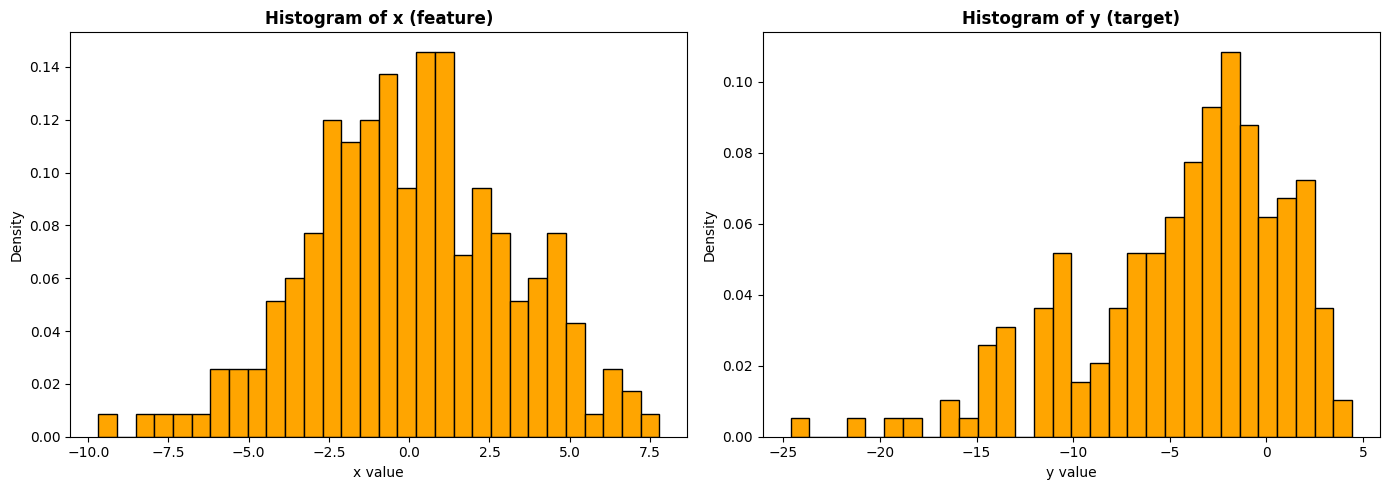

In [3]:
#Load data
data = jnp.load("./data_assignment3.npz")
x, y = data["x"], data["t"]

# load with NumPy
data = np.load("./data_assignment3.npz")
x_np, y_np = data["x"], data["t"]

# Normal distribution
log_npdf = lambda x, m, v: -0.5*(x-m)**2/(v) - 0.5*jnp.log(2*jnp.pi*v)
npdf = lambda x, m, v: jnp.exp(log_npdf(x, m, v))

# Half-normal distribution
log_half_npdf = lambda x, m, v: jnp.log(2) -0.5*(x-m)**2/(v) - 0.5*jnp.log(2*jnp.pi*v)
half_npdf = lambda x, m, v: jnp.exp(log_half_npdf(x, m, v))

# Create histograms for x and y
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram for x (feature)
axes[0].hist(x, bins=30, edgecolor='black', density=True, color='orange')
axes[0].set_title('Histogram of x (feature)', fontweight='bold')
axes[0].set_xlabel('x value')
axes[0].set_ylabel('Density')

# Histogram for y (target)
axes[1].hist(y, bins=30, edgecolor='black', density=True, color='orange')
axes[1].set_title('Histogram of y (target)', fontweight='bold')
axes[1].set_xlabel('y value')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()


In [4]:
#2.2
def evaluate_log_joint(x, y, w0, w1, v, sigma0, sigma1, tau):
    """
    Evaluate the marginalized log joint distribution
    log p(y, w0, w1, v, sigma0, sigma1, tau | x)
    
    Inputs:
        x         : (N, D) JAX array (feature matrix, NO bias yet)
        y         : (N,)   JAX array (targets)
        w0, w1, v : (D+1,) JAX arrays (parameters including bias term)
        sigma0    : scalar
        sigma1    : scalar
        tau       : scalar
    Returns:
        log_joint : scalar (log probability)
    """

    # Adding a bias if needed
    if x.ndim == 1:
        x = x[:, None]
    x_bar = jnp.hstack([x, jnp.ones((x.shape[0], 1))])

    # Helper: log pdf of normal
    def log_normal(y, mu, sigma):
        return -0.5 * (jnp.log(2 * jnp.pi) + 2 * jnp.log(sigma) + ((y - mu) / sigma)**2)

    # Helper: log prior of half-normal
    def log_half_normal(x):
        return jnp.where(x > 0,
                         jnp.log(2.0) + log_normal(x, 0.0, 1.0),
                         -jnp.inf)

    # Mixture likelihood per datapoint
    def per_datapoint_loglik(x_n, y_n):
        pi_n = jax.nn.sigmoid(jnp.dot(v, x_n))
        mu0 = jnp.dot(w0, x_n)
        mu1 = jnp.dot(w1, x_n)
        log_p0 = log_normal(y_n, mu0, sigma0)
        log_p1 = log_normal(y_n, mu1, sigma1)
        return logsumexp(jnp.array([
            jnp.log1p(-pi_n) + log_p0,
            jnp.log(pi_n) + log_p1
        ]))

    # Vectorized over all datapoints
    total_loglik = jnp.sum(vmap(per_datapoint_loglik)(x_bar, y))

    # Priors
    logp_w0 = jnp.sum(log_normal(w0, 0.0, tau))
    logp_w1 = jnp.sum(log_normal(w1, 0.0, tau))
    logp_v  = jnp.sum(log_normal(v , 0.0, tau))
    logp_tau = log_half_normal(tau)
    logp_sigma0 = log_half_normal(sigma0)
    logp_sigma1 = log_half_normal(sigma1)

    total_logprior = logp_w0 + logp_w1 + logp_v + logp_tau + logp_sigma0 + logp_sigma1

    return total_loglik + total_logprior


x = jnp.asarray(x_np)
y = jnp.asarray(y_np)

if x.ndim == 1:
    x = x[:, None]

# Random parameters
key = jax.random.PRNGKey(0)
D = x.shape[1]
w0 = jax.random.normal(key, (D+1,)) * 0.1
w1 = jax.random.normal(key, (D+1,)) * 0.1
v  = jax.random.normal(key, (D+1,)) * 0.1
sigma0 = 1.0
sigma1 = 1.0
tau    = 1.0

# Evaluate
logp = evaluate_log_joint(x, y, w0, w1, v, sigma0, sigma1, tau)

print("Marginalized log joint =", float(logp))



Marginalized log joint = -5301.0703125


Acceptance ratio: 0.55


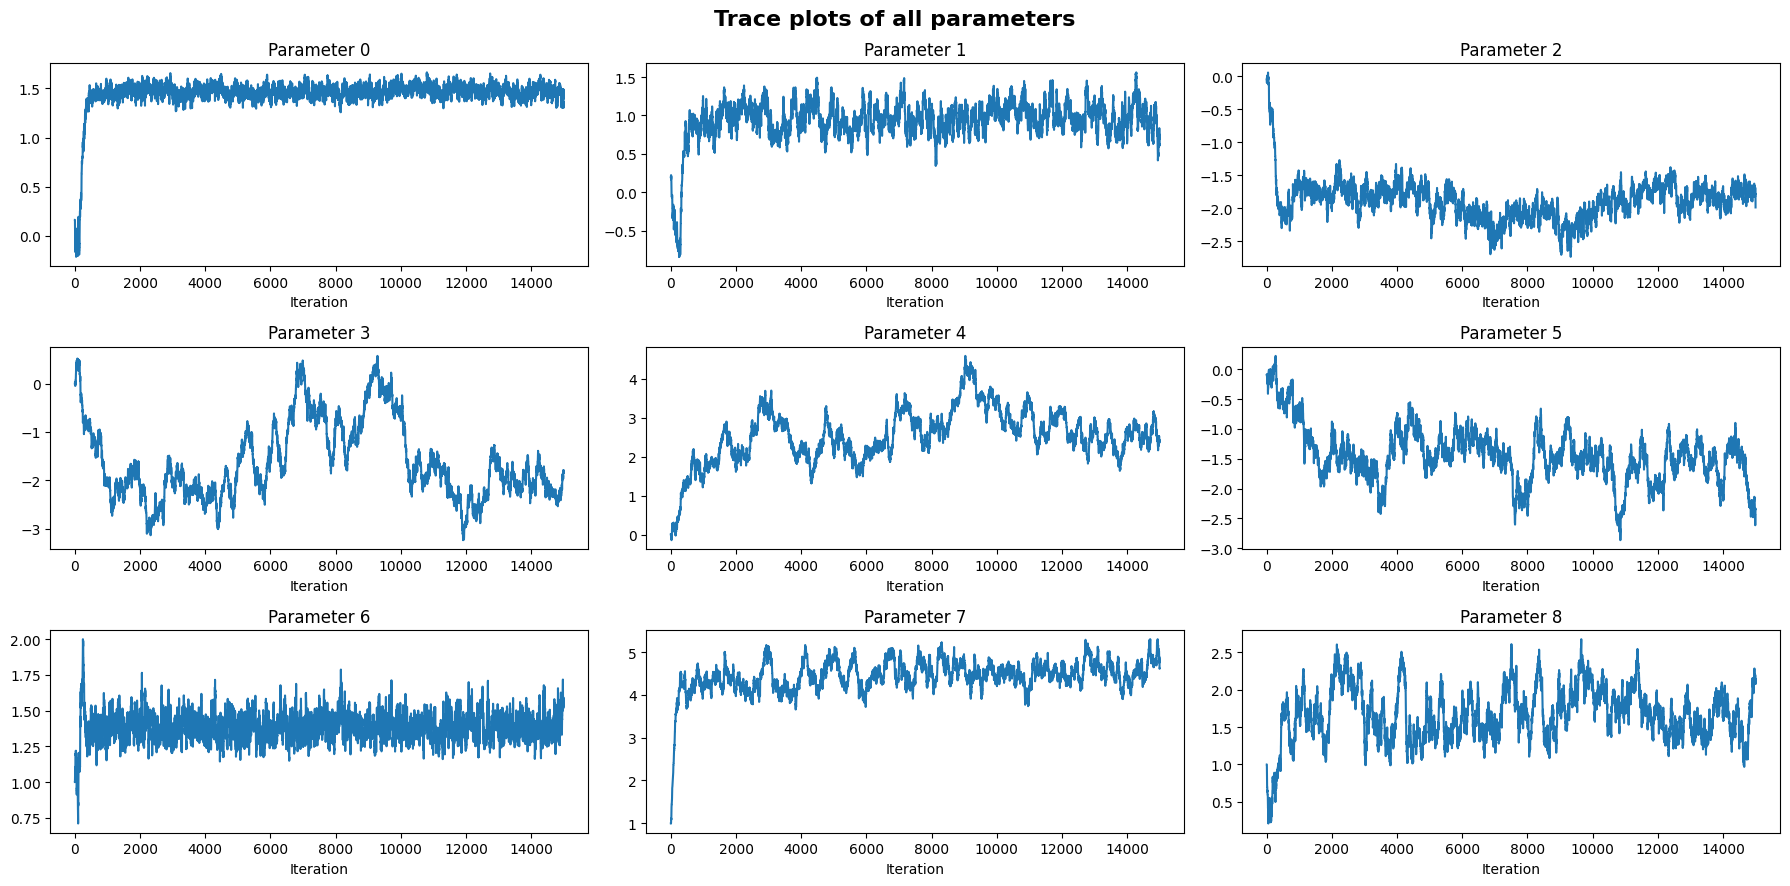

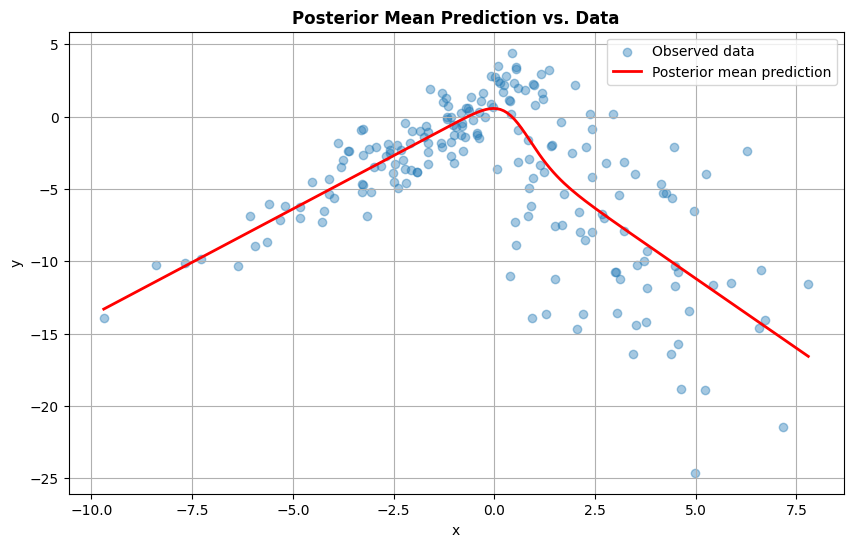

In [5]:
#2.3
def metropolis(log_target, num_params, tau, num_iter, theta_init=None, seed=0):    
    """ Runs a Metropolis-Hastings sampler 
    
        Arguments:
        log_target:         function for evaluating the log target distribution, i.e. log \tilde{p}(theta). The function expect a parameter of size num_params.
        num_params:         number of parameters of the joint distribution (integer)
        tau:                standard deviation of the Gaussian proposal distribution (positive real)
        num_iter:           number of iterations (integer)
        theta_init:         vector of initial parameters (np.array with shape (num_params) or None)        
        seed:               seed (integer)

        returns
        thetas              np.array with MCMC samples (np.array with shape (num_iter+1, num_params))
    """ 
    
    # set initial key
    key = random.PRNGKey(seed)

    if theta_init is None:
        theta_init = jnp.zeros((num_params))
    
    # prepare lists 
    thetas = [theta_init]
    accepts = []
    log_p_theta = log_target(theta_init)
    
    for k in range(num_iter):

        # update keys: key_proposal for sampling proposal distribution and key_accept for deciding whether to accept or reject.
        key, key_proposal, key_accept = random.split(key, num=3)

        # get the last value for theta and generate new proposal candidate
        theta_cur = thetas[-1]
        theta_star = theta_cur + tau*random.normal(key_proposal, shape=(num_params, ))
        
        # evaluate the log density for the candidate sample
        log_p_theta_star = log_target(theta_star)

        # compute acceptance probability
        log_r = log_p_theta_star - log_p_theta
        A = min(1, jnp.exp(log_r))
        
        # accept new candidate with probability A
        if random.uniform(key_accept) < A:
            theta_next = theta_star
            log_p_theta = log_p_theta_star
            accepts.append(1)
        else:
            theta_next = theta_cur
            accepts.append(0)

        thetas.append(theta_next)


        
    print('Acceptance ratio: %3.2f' % jnp.mean(jnp.array(accepts)))
        
    # return as np.array
    thetas = jnp.stack(thetas)

    # check dimensions and return
    assert thetas.shape == (num_iter+1, num_params), f'The shape of thetas was expected to be ({num_iter+1}, {num_params}), but the actual shape was {thetas.shape}. Please check your code.'
    return thetas


# Setup: number of parameters based on your data (D = 1 → 3*(1+1) + 3 = 9)
D = x.shape[1]
num_params = (D + 1) * 3 + 3  # w0, w1, v (each D+1) + sigma0 + sigma1 + tau

# Helper: unpack flat theta vector
def unpack_theta(theta):
    w0 = theta[0:D+1]
    w1 = theta[D+1:2*(D+1)]
    v  = theta[2*(D+1):3*(D+1)]
    sigma0 = theta[3*(D+1)]
    sigma1 = theta[3*(D+1) + 1]
    tau    = theta[3*(D+1) + 2]
    return w0, w1, v, sigma0, sigma1, tau

# Define target distribution: log joint probability
def log_target(theta):
    w0, w1, v, sigma0, sigma1, tau = unpack_theta(theta)
    return evaluate_log_joint(x, y, w0, w1, v, sigma0, sigma1, tau)

# Initial point: small random values + enforce sigma0, sigma1, tau > 0
key = jax.random.PRNGKey(0)
theta_init = jax.random.normal(key, (num_params,)) * 0.1
theta_init = theta_init.at[-3:].set(1.0)  # last 3: sigma0, sigma1, tau

# Sampler settings
num_iterations = 15000
tau_mh = 0.05
warm_up = int(0.5 * num_iterations)

# Run MCMC
samples = metropolis(log_target, num_params, tau_mh, num_iterations, theta_init=theta_init, seed=0)

#Plots of the parameters

fig, axes = plt.subplots(3, 3, figsize=(18, 9))
axes = axes.flatten()
for i in range(num_params):
    axes[i].plot(samples[:, i])
    axes[i].set_title(f"Parameter {i}")
    axes[i].set_xlabel("Iteration")
plt.suptitle("Trace plots of all parameters", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Posterior mean prediction

posterior_means = jnp.mean(samples[warm_up:], axis=0)
w0_mean, w1_mean, v_mean, sigma0_mean, sigma1_mean, tau_mean = unpack_theta(posterior_means)

x_line = jnp.linspace(x.min(), x.max(), 200)
x_line_bar = jnp.hstack([x_line[:, None], jnp.ones((200, 1))])
pi_line = jax.nn.sigmoid(x_line_bar @ v_mean)
mean_prediction = (1 - pi_line) * (x_line_bar @ w0_mean) + pi_line * (x_line_bar @ w1_mean)

plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.4, label='Observed data')
plt.plot(x_line, mean_prediction, color='red', linewidth=2, label='Posterior mean prediction')
plt.title("Posterior Mean Prediction vs. Data", fontweight='bold')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
#2.4

# Your parameter names (for display)
param_names = [
    "w0[0]", "w0[1]",
    "w1[0]", "w1[1]",
    "v[0]",  "v[1]",
    "sigma0", "sigma1", "tau"
]

# Use only post-warm-up samples
posterior_samples = samples[warm_up:]
# 
# Compute statistics
posterior_mean = jnp.mean(posterior_samples, axis=0)
lower_bound = jnp.percentile(posterior_samples, 2.5, axis=0)
upper_bound = jnp.percentile(posterior_samples, 97.5, axis=0)

# Combine into a DataFrame
summary_df = pd.DataFrame({
    "Parameter": param_names,
    "Mean": posterior_mean,
    "2.5% CI": lower_bound,
    "97.5% CI": upper_bound
})

# Display the table
print(summary_df.round(4))

  Parameter    Mean  2.5% CI  97.5% CI
0     w0[0]  1.4745   1.3525    1.5935
1     w0[1]  0.9826   0.6491    1.3374
2     w1[0] -1.9275  -2.4292   -1.5351
3     w1[1] -1.5552  -2.7827    0.1666
4      v[0]  2.8561   2.0153    4.1781
5      v[1] -1.6333  -2.4378   -0.9601
6    sigma0  1.3957   1.2350    1.5892
7    sigma1  4.5547   4.0240    5.0756
8       tau  1.7241   1.2022    2.3373


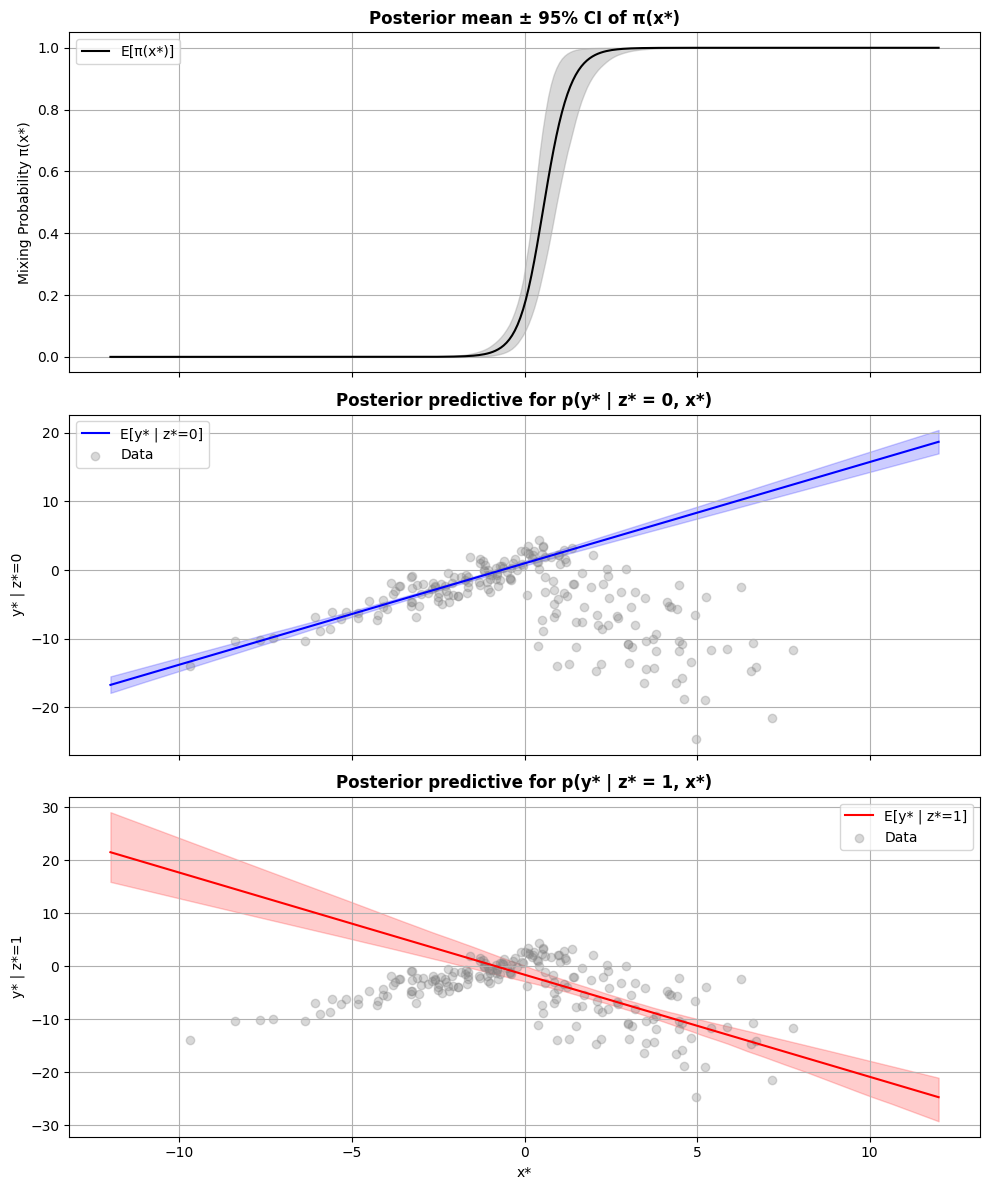

In [7]:
#2.5

# x* range for prediction
x_star = jnp.linspace(-12, 12, 300)
x_star_bar = jnp.hstack([x_star[:, None], jnp.ones((x_star.shape[0], 1))])

# Use MCMC samples after warm-up
posterior_samples = samples[warm_up:]

# Allocate arrays for predictions
pi_preds = []
y0_preds = []
y1_preds = []

for theta in posterior_samples[::10]:  # subsample for speed
    w0, w1, v, sigma0, sigma1, tau = unpack_theta(theta)

    pi_x = jax.nn.sigmoid(x_star_bar @ v)
    mu0_x = x_star_bar @ w0
    mu1_x = x_star_bar @ w1

    # Store for quantiles
    pi_preds.append(pi_x)
    y0_preds.append(mu0_x)
    y1_preds.append(mu1_x)

# Stack predictions
pi_preds = jnp.stack(pi_preds)
y0_preds = jnp.stack(y0_preds)
y1_preds = jnp.stack(y1_preds)

# Compute mean and 95% credible intervals
def summarize(samples):
    lower = jnp.percentile(samples, 2.5, axis=0)
    upper = jnp.percentile(samples, 97.5, axis=0)
    mean  = jnp.mean(samples, axis=0)
    return mean, lower, upper

pi_mean, pi_lower, pi_upper = summarize(pi_preds)
y0_mean, y0_lower, y0_upper = summarize(y0_preds)
y1_mean, y1_lower, y1_upper = summarize(y1_preds)


# Plots
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# π(x*)
axs[0].plot(x_star, pi_mean, label="E[π(x*)]", color='black')
axs[0].fill_between(x_star, pi_lower, pi_upper, color='gray', alpha=0.3)
axs[0].set_title("Posterior mean ± 95% CI of π(x*)", fontweight='bold')
axs[0].set_ylabel("Mixing Probability π(x*)")
axs[0].grid(True)
axs[0].legend()

# Component 0
axs[1].plot(x_star, y0_mean, label="E[y* | z*=0]", color='blue')
axs[1].fill_between(x_star, y0_lower, y0_upper, color='blue', alpha=0.2)
axs[1].scatter(x, y, alpha=0.3, label="Data", color='gray')
axs[1].set_title("Posterior predictive for p(y* | z* = 0, x*)", fontweight='bold')
axs[1].set_ylabel("y* | z*=0")
axs[1].grid(True)
axs[1].legend()

# Component 1
axs[2].plot(x_star, y1_mean, label="E[y* | z*=1]", color='red')
axs[2].fill_between(x_star, y1_lower, y1_upper, color='red', alpha=0.2)
axs[2].scatter(x, y, alpha=0.3, label="Data", color='gray')
axs[2].set_title("Posterior predictive for p(y* | z* = 1, x*)", fontweight='bold')
axs[2].set_ylabel("y* | z*=1")
axs[2].set_xlabel("x*")
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()


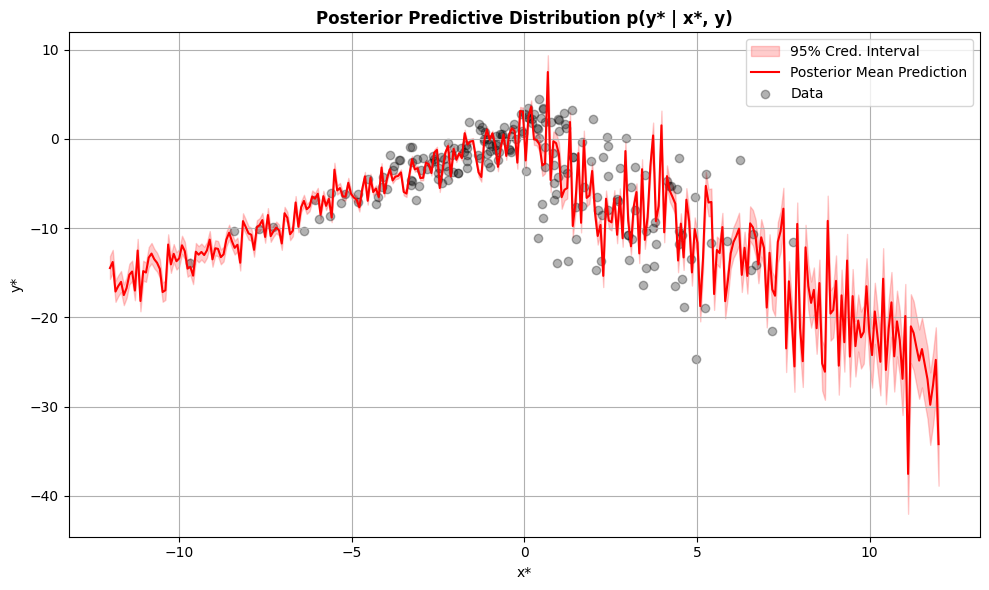

In [8]:
#2.6

y_star_preds = []

for theta in posterior_samples[::10]:  # subsample for speed
    w0, w1, v, sigma0, sigma1, tau = unpack_theta(theta)

    pi_x = jax.nn.sigmoid(x_star_bar @ v)
    mu0 = x_star_bar @ w0
    mu1 = x_star_bar @ w1

    # Predictive distribution: mixture of Gaussians (we sample for each x)
    # Sample from both components
    y0_sample = mu0 + sigma0 * random.normal(key, shape=mu0.shape)
    y1_sample = mu1 + sigma1 * random.normal(key, shape=mu1.shape)

    # Weighted mixture
    y_mix = (1 - pi_x) * y0_sample + pi_x * y1_sample
    y_star_preds.append(y_mix)

# Stack predictions
y_star_preds = jnp.stack(y_star_preds)

# Compute mean and 95% credible interval
y_mean, y_lower, y_upper = summarize(y_star_preds)

# Plot
plt.figure(figsize=(10, 6))
plt.fill_between(x_star, y_lower, y_upper, color='red', alpha=0.2, label="95% Cred. Interval")
plt.plot(x_star, y_mean, color='red', label="Posterior Mean Prediction")
plt.scatter(x, y, alpha=0.3, label="Data", color='black')
plt.title("Posterior Predictive Distribution p(y* | x*, y)", fontweight='bold')
plt.xlabel("x*")
plt.ylabel("y*")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()